In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from imblearn.over_sampling import RandomOverSampler
import numpy as np
from keras.regularizers import l2

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Load the training csv into a panda dataset.

In [2]:
steel_plate_dataset = pd.read_csv('kaggle/input/playground-series-s4e3/train.csv')

# Overview

In [3]:
steel_plate_dataset.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0,584,590,909972,909977,16,8,5,2274,113,...,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,1,808,816,728350,728372,433,20,54,44478,70,...,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,...,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,3,781,789,3353146,3353173,210,16,29,3202,114,...,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,4,1540,1560,618457,618502,521,72,67,48231,82,...,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1


In [4]:
steel_plate_dataset.tail()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
19214,19214,749,757,143210,143219,17,4,4,2193,122,...,-0.1429,0.0044,0.2901,0,0,0,1,0,0,0
19215,19215,723,735,2488529,2488541,231,17,26,27135,104,...,0.7222,-0.0989,0.5378,0,0,0,0,0,0,1
19216,19216,6,31,1578055,1578129,780,114,98,71112,41,...,0.7719,-0.4283,0.9997,1,0,0,0,0,0,0
19217,19217,9,18,1713172,1713184,126,13,26,14808,88,...,0.9610,-0.1162,0.3509,0,0,0,0,0,0,1
19218,19218,1505,1525,1733458,1733471,182,24,33,22785,98,...,0.5263,-0.1120,0.6619,0,0,0,0,0,1,0


# Exploratory Data Analysis (EDA)

## Checking for null values

In [5]:
steel_plate_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19219 entries, 0 to 19218
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     19219 non-null  int64  
 1   X_Minimum              19219 non-null  int64  
 2   X_Maximum              19219 non-null  int64  
 3   Y_Minimum              19219 non-null  int64  
 4   Y_Maximum              19219 non-null  int64  
 5   Pixels_Areas           19219 non-null  int64  
 6   X_Perimeter            19219 non-null  int64  
 7   Y_Perimeter            19219 non-null  int64  
 8   Sum_of_Luminosity      19219 non-null  int64  
 9   Minimum_of_Luminosity  19219 non-null  int64  
 10  Maximum_of_Luminosity  19219 non-null  int64  
 11  Length_of_Conveyer     19219 non-null  int64  
 12  TypeOfSteel_A300       19219 non-null  int64  
 13  TypeOfSteel_A400       19219 non-null  int64  
 14  Steel_Plate_Thickness  19219 non-null  int64  
 15  Ed

- This dataset doesn't have any null values

## 1. Detect Outliers

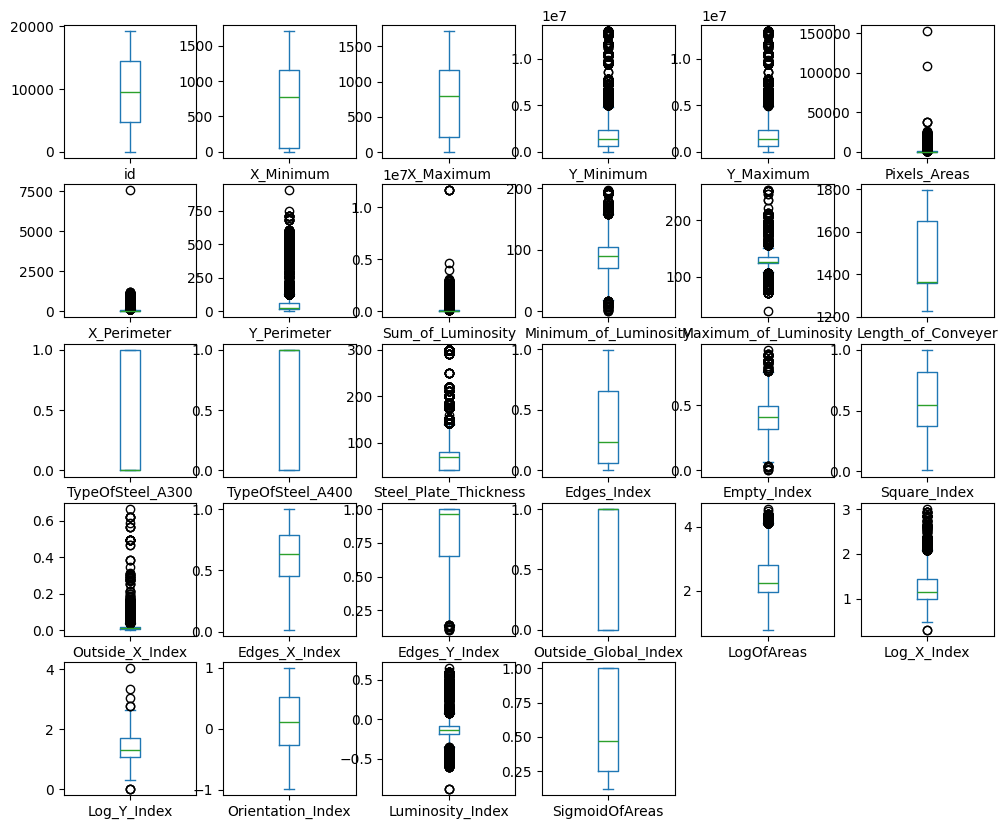

In [6]:
features = steel_plate_dataset.columns[:-7]
steel_plate_dataset[features].plot(kind='box', subplots=True, layout=(5,6), figsize=(12,10))
plt.show()

- In the above data we can see Pixel_Areas and X_perimeter have outlier gaps.

## 2. Check data balance

In [7]:
steel_plate_dataset.describe()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
count,19219.000000,19219.000000,19219.000000,1.921900e+04,1.921900e+04,19219.000000,19219.000000,19219.000000,1.921900e+04,19219.000000,...,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000
mean,9609.000000,709.854675,753.857641,1.849756e+06,1.846605e+06,1683.987616,95.654665,64.124096,1.918467e+05,84.808419,...,0.102742,-0.138382,0.571902,0.076279,0.059837,0.178573,0.029554,0.025235,0.247828,0.341225
std,5548.191747,531.544189,499.836603,1.903554e+06,1.896295e+06,3730.319865,177.821382,101.054178,4.420247e+05,28.800344,...,0.487681,0.120344,0.332219,0.265450,0.237190,0.383005,0.169358,0.156844,0.431762,0.474133
min,0.000000,0.000000,4.000000,6.712000e+03,6.724000e+03,6.000000,2.000000,1.000000,2.500000e+02,0.000000,...,-0.988400,-0.885000,0.119000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4804.500000,49.000000,214.000000,6.574680e+05,6.575020e+05,89.000000,15.000000,14.000000,9.848000e+03,70.000000,...,-0.272700,-0.192500,0.253200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9609.000000,777.000000,796.000000,1.398169e+06,1.398179e+06,168.000000,25.000000,23.000000,1.823800e+04,90.000000,...,0.111100,-0.142600,0.472900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,14413.500000,1152.000000,1165.000000,2.368032e+06,2.362511e+06,653.000000,64.000000,61.000000,6.797800e+04,105.000000,...,0.529400,-0.084000,0.999400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,19218.000000,1705.000000,1713.000000,1.298766e+07,1.298769e+07,152655.000000,7553.000000,903.000000,1.159141e+07,196.000000,...,0.991700,0.642100,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- From the above statistics, we note that Pastry Z_Scratch K_Scatch Stains Dirtiness have very less mean compared to Bumps, Other_Faults.
- We need to balance these classes to fix this issue.

# Data Preprocessing

## 1. Remove outliers

<Axes: >

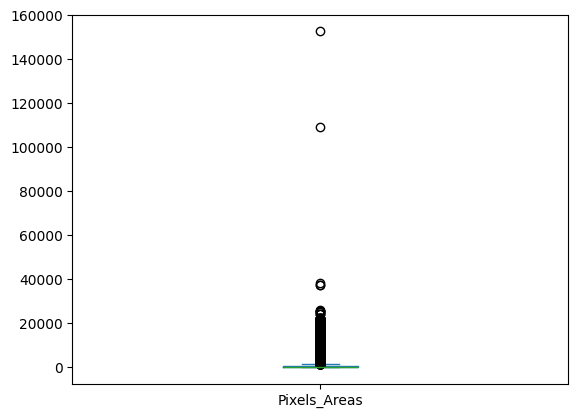

In [8]:
steel_plate_dataset['Pixels_Areas'].plot(kind='box')

<Axes: >

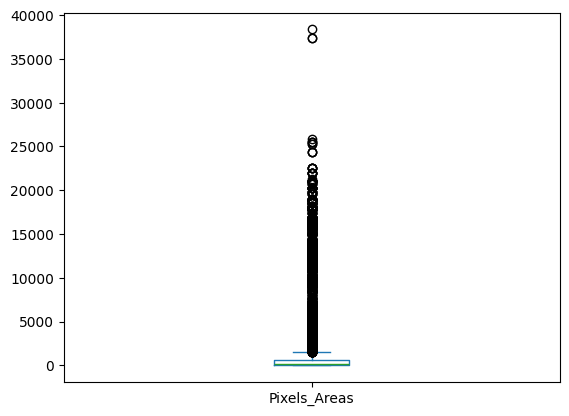

In [9]:
# Pixels_Areas has a big outlier that might skew results.
steel_plate_dataset = steel_plate_dataset[steel_plate_dataset['Pixels_Areas']<40000]
# Verifying filtering of Pixels_Areas.
steel_plate_dataset['Pixels_Areas'].plot(kind='box')

<Axes: >

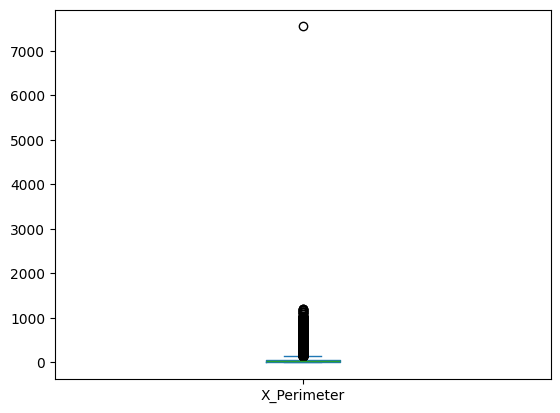

In [10]:
steel_plate_dataset['X_Perimeter'].plot(kind='box')

<Axes: >

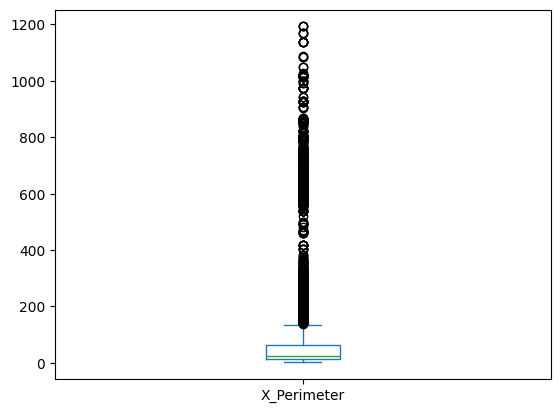

In [11]:
# X_Perimeter has a big outlier that might skew results.
steel_plate_dataset = steel_plate_dataset[steel_plate_dataset['X_Perimeter']<2000]
# Verifying filtering of Pixels_Areas.
steel_plate_dataset['X_Perimeter'].plot(kind='box')

## 2. Balancing data

In [12]:
X = steel_plate_dataset.drop(columns=['id', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults'])
y = steel_plate_dataset[['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']]

defaults = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
encoded_data = np.array(y)
max_indices = encoded_data.argmax(axis=1)
y = pd.DataFrame(data =[defaults[ind] for ind in max_indices], columns=[''])

# Perform oversampling to balance the dataset
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

In [13]:
print(y_resampled.value_counts())
print(X_resampled.shape)
print(y_resampled.shape)

            
Bumps           6540
Dirtiness       6540
K_Scatch        6540
Other_Faults    6540
Pastry          6540
Stains          6540
Z_Scratch       6540
Name: count, dtype: int64
(45780, 27)
(45780, 1)


## 3. Hot encode categorical values

In [14]:
encoded_data = pd.get_dummies(y_resampled, dtype=int)
encoded_data

,_Bumps,_Dirtiness,_K_Scatch,_Other_Faults,_Pastry,_Stains,_Z_Scratch
0,0,0,0,0,0,1,0
1,0,0,0,1,0,0,0
2,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0
4,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...
45775,0,0,0,0,0,0,1
45776,0,0,0,0,0,0,1
45777,0,0,0,0,0,0,1
45778,0,0,0,0,0,0,1


In [15]:
y_resampled = encoded_data

## 4. Splitting the dataset into training, validation, and test sets

In [16]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=31)
Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, test_size=0.2, random_state=31) 

## 5. Scale the features

In [17]:
scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xval = scaler.transform(Xval)
Xtest = scaler.transform(Xtest)

# Creating a neural network in Keras

In [18]:
neural_model = Sequential([
    Input(shape=(Xtrain.shape[1],)),  
    Dense(128, activation='relu'),     
    Dense(64, activation='relu'),     
    Dense(7, activation='softmax') 
])

# Compile the model
neural_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
result = neural_model.fit(Xtrain, ytrain, epochs=50, validation_data=(Xval, yval), verbose=0,)

# Plot the train and Validation Loss Functions

#### Generating a train and validation loss functions to determine number of epochs and evidence of overfitting.

Text(0.5, 0, 'Epoch')

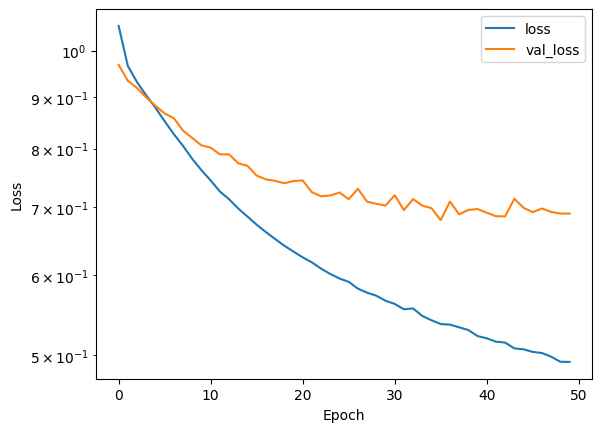

In [19]:
plt.semilogy(result.history['loss'], label='loss')
plt.semilogy(result.history['val_loss'], label='val_loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epoch')

- Retained the model with proper number of epochs

# Use the splitted test data set to analyze the model effectiveness

- Generated predicted labels and probabilities of those labels.

In [20]:
# Make predictions and save in dataframe
yp = neural_model.predict(Xtest)
yp = pd.DataFrame(yp,columns=ytest.columns)

# Extract predicted labels and probabilities
predicted_label = yp.idxmax(axis=1)
predicted_prob = yp.max(axis=1)
actual_label = ytest.idxmax(axis=1)

287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


# Display probabilities

- Display probabilities of faults with the most likely label highlighted and the actual label displayed.(Last 50 rows in test data)

In [21]:
yp['Actual fault'] = actual_label.values
numeric_cols = yp.select_dtypes(include=['number']).columns
highlighted = yp.tail(50).style.highlight_max(axis=1, subset=numeric_cols)
highlighted

,_Bumps,_Dirtiness,_K_Scatch,_Other_Faults,_Pastry,_Stains,_Z_Scratch,Actual fault
9106,0.055291,0.132606,0.148811,0.163525,0.499430,0.000000,0.000337,_K_Scatch
9107,0.000039,0.000000,0.000003,0.012911,0.000953,0.986094,0.000000,_Stains
9108,0.001552,0.981704,0.009854,0.004746,0.002144,0.000000,0.000000,_Dirtiness
9109,0.004237,0.962531,0.000090,0.020364,0.012768,0.000000,0.000009,_Dirtiness
9110,0.290528,0.000000,0.000006,0.074914,0.622411,0.000428,0.011713,_Bumps
9111,0.698881,0.000011,0.000098,0.217819,0.083192,0.000000,0.000001,_Bumps
9112,0.001662,0.000000,0.000000,0.009679,0.004905,0.000000,0.983755,_Z_Scratch
9113,0.138393,0.000000,0.000000,0.311723,0.549884,0.000000,0.000000,_Other_Faults
9114,0.036627,0.000117,0.000029,0.097687,0.031700,0.000000,0.833840,_Z_Scratch
9115,0.106532,0.000000,0.000001,0.267634,0.625833,0.000000,0.000000,_Pastry


# Generating a confusion matrix

<Axes: >

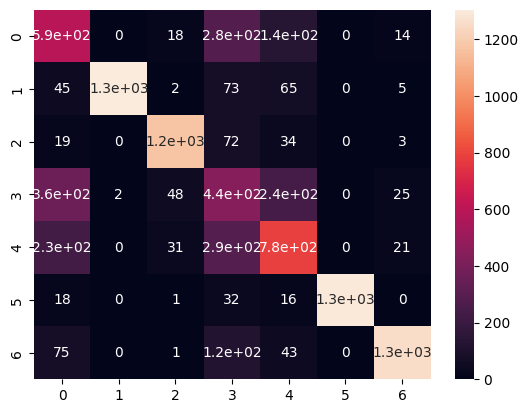

In [22]:
cm = confusion_matrix(predicted_label, actual_label)
sns.heatmap(cm, annot=True)

# Score, Accuracy and Evaluation of Neural Network

In [23]:
score1, acc1 = neural_model.evaluate(Xtrain, ytrain)
score2, acc2 = neural_model.evaluate(Xtest, ytest)

yp_numeric = yp.drop(columns=['Actual fault'])

mse = mean_squared_error(ytest, yp_numeric, multioutput='raw_values')
rmse = np.sqrt(mse)
mae = mean_absolute_error(ytest, yp_numeric, multioutput='raw_values')

print(f"MSE:\n{mse}")
print(f"RMSE:\n{rmse}")
print(f"MAE:\n{mae}")

916/916 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - accuracy: 0.8130 - loss: 0.4670
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step - accuracy: 0.7402 - loss: 0.6978
MSE:
[0.08864117 0.01255896 0.02004706 0.10924751 0.07926129 0.00617951
 0.02548691]
RMSE:
[0.29772667 0.11206676 0.14158764 0.33052611 0.28153381 0.07860983
 0.1596462 ]
MAE:
[0.15351051 0.02305261 0.03526329 0.20027884 0.1434579  0.00959271
 0.04512761]


# Scikit Clasifiers

In [24]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import MultiOutputClassifier

# Create models

In [25]:
ada = AdaBoostClassifier()
lr = LogisticRegression()
nb = GaussianNB()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
svc = SVC()
mlp = MLPClassifier(max_iter=50)
clist = [ada, lr, nb, knn, dt, rf, svc, mlp]
mlist = [None]*8

# Train Models

In [26]:
for i,m in enumerate(clist):
    mlist[i] = MultiOutputClassifier(m).fit(Xtrain, ytrain)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R

# Evaluate classifier models

In [27]:
x = pd.DataFrame()
n = ['Keras/TF NN']; s1 = [score1]; s2 = [score2]
for i,m in enumerate(mlist):
    n.append(str(m.estimator))
    s1.append(m.score(Xtrain, ytrain))
    s2.append(m.score(Xtest, ytest))

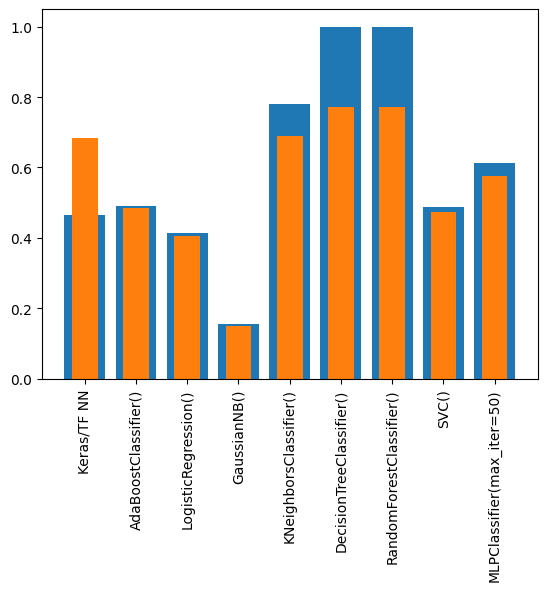

In [28]:
plt.bar(n, s1, label = 'Train')
plt.bar(n, s2, width=0.5, label='Test')
plt.xticks(rotation=90)
plt.legend
plt.show()

In [ ]:
for i, m in enumerate(mlist):
    y_pred = m.predict(Xtest)
    
    model_mse = mean_squared_error(ytest, y_pred, multioutput='raw_values')

    model_rmse = np.sqrt(model_mse)

    model_mae = mean_absolute_error(ytest, y_pred, multioutput='raw_values')

    print(f"Model {m.estimator}: \nMSE: \n{model_mse}, \nRMSE: \n{model_rmse}, \nMAE: \n{model_mae}\n")

Model AdaBoostClassifier(): 
MSE: 
[0.14056356 0.08868502 0.02981651 0.14438619 0.14121887 0.02107907
 0.06181739], 
RMSE: 
[0.37491808 0.29780029 0.17267459 0.37998183 0.375791   0.14518634
 0.24863103], 
MAE: 
[0.14056356 0.08868502 0.02981651 0.14438619 0.14121887 0.02107907
 0.06181739]

Model LogisticRegression(): 
MSE: 
[0.14340323 0.11282219 0.03112713 0.14231105 0.14067278 0.03254696
 0.09065094], 
RMSE: 
[0.37868619 0.33589015 0.17642882 0.37724137 0.37506371 0.18040777
 0.30108294], 
MAE: 
[0.14340323 0.11282219 0.03112713 0.14231105 0.14067278 0.03254696
 0.09065094]

Model GaussianNB(): 
MSE: 
[0.5904325  0.36795544 0.0358235  0.5151813  0.45958934 0.07306684
 0.24858017], 
RMSE: 
[0.76839606 0.60659331 0.18927098 0.71776131 0.67793019 0.27030879
 0.49857814], 
MAE: 
[0.5904325  0.36795544 0.0358235  0.5151813  0.45958934 0.07306684
 0.24858017]

Model KNeighborsClassifier(): 
MSE: 
[0.13816077 0.02927042 0.02719528 0.15312363 0.1170817  0.00982962
 0.05646571], 
RMSE: 
[0.

# Model selection

- With all the evaluations the Keras Neural Network seems to be the most consistent and reliable model.

# Make Prediction on Test set

In [ ]:
test_data = pd.read_csv("kaggle/input/playground-series-s4e3/test.csv")
y = test_data.drop(columns=['id'])
test_df_scaled = scaler.fit_transform(y)
predictions = neural_model.predict(test_df_scaled)

In [ ]:
predictions.shape

In [ ]:
submission = pd.DataFrame(predictions, columns=['Bumps', 'Dirtiness', 'K_Scatch', 'Other_Faults', 'Pastry', 'Stains', 'Z_Scratch'])
submission.insert(0, 'id', test_data['id'])

In [ ]:
submission.head()

In [ ]:
# Save the combined data to a CSV file
submission.to_csv("submission.csv", index=False)

# Save the model

In [ ]:
neural_model.save('model.h5')